In [51]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_1_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [52]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [53]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_1_crimes_500m                                      1.329944e-70   
                                                 pre_treatment_change_in_group_1_crimes_500m                                     1.697827e-01   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                              1.076963e-22   
                                                 job_density_2013                                                                1.918954e-95   
                                                 med_hhinc2016                                                                   3.928415e-13   
                                                 poor_share2010                                                                  2.831681e-04   
                                                 popdensity2010                                                                  7.603941e-03   
Panel C: Case Initiation                         for_cause                                                                       1.526074e-01   
                                                 no_cause                                                                        4.554823e-01   
                                                 non_payment                                                                     2.152745e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                        1.485919e-01   
                                                 hasAttyP                                                                        4.215376e-03   
                                                 isEntityD                                                                       2.147458e-01   
                                                 isEntityP                                                                       1.485047e-03   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_1_crimes_500m      4.989915e-01  
                                                 pre_treatment_change_in_group_1_crimes_500m     3.733462e-02  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              8.133641e-01  
                                                 job_density_2013                                5.501121e-01  
                                                 med_hhinc2016                                   1.427126e-02  
                                                 poor_share2010                                  4.904136e-03  
                                                 popdensity2010                                  6.737331e-01  
Panel C: Case Initiation                         for_cause                                       5.801068e-03  
                                                 no_cause                                        3.431724e-02  
                                                 non_payment                                     3.013004e-07  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                        2.406617e-08  
                                                 hasAttyP                                

In [54]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                      Cases Won by Plaintiff   
Panel A Total Group 1 Incidents, 2017              81.749738   
Panel B Bachelor's degree, 2010                     0.316407   
        Job density, 2013                       16161.032515   
        Median household income, 2016           47553.063874   
        Poverty rate, 2010                          0.279638   
        Population density, 2010                23320.185868   
Panel C Filing for nonpayment                       0.716230   
Panel D Plaintiff has attorney                      0.884817   
        Plaintiff is entity                         0.808377   

                                      Difference in Cases Won by Defendant  \
                                                                Unweighted   
Panel A Total Group 1 Incidents, 2017                            -2.951897   
Panel B Bachelor's degree, 2010                                   0.002512   
        Job density, 2013                                     -1272.661768   
        Median household income, 2016                          2997.870414   
        Poverty rate, 2010                                       -0.021030   
        Population density, 2010                               -297.766413   
Panel C Filing for nonpayment                                    -0.106658   
Panel D Plaintiff has attorney                                   -0.049788   
        Plaintiff is entity                                      -0.077182   

                                                                            
                                           \emph{p}     Weighted  \emph{p}  
Panel A Total Group 1 Incidents, 2017  4.989915e-01    -2.415777  0.583854  
Panel B Bachelor's degree, 2010        8.133641e-01    -0.008171  0.440384  
        Job density, 2013              5.501121e-01  -535.856316  0.802979  
        Median household income, 2016  1.427126e-02 -1006.450157  0.324677  
        Poverty rate, 2010             4.904136e-03    -0.009188  0.205728  
        Population density, 2010       6.737331e-01  -643.095937  0.366474  
Panel C Filing for nonpayment          3.013004e-07    -0.027999  0.078731  
Panel D Plaintiff has attorney         4.887193e-04    -0.027656  0.046453  
        Plaintiff is entity            1.569652e-05    -0.027947  0.078149

In [55]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [56]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:09<00:00, 115.07it/s]


-0.49825099504971676
-0.07357946845086094
-0.10537670474161963
0.2174087336119947


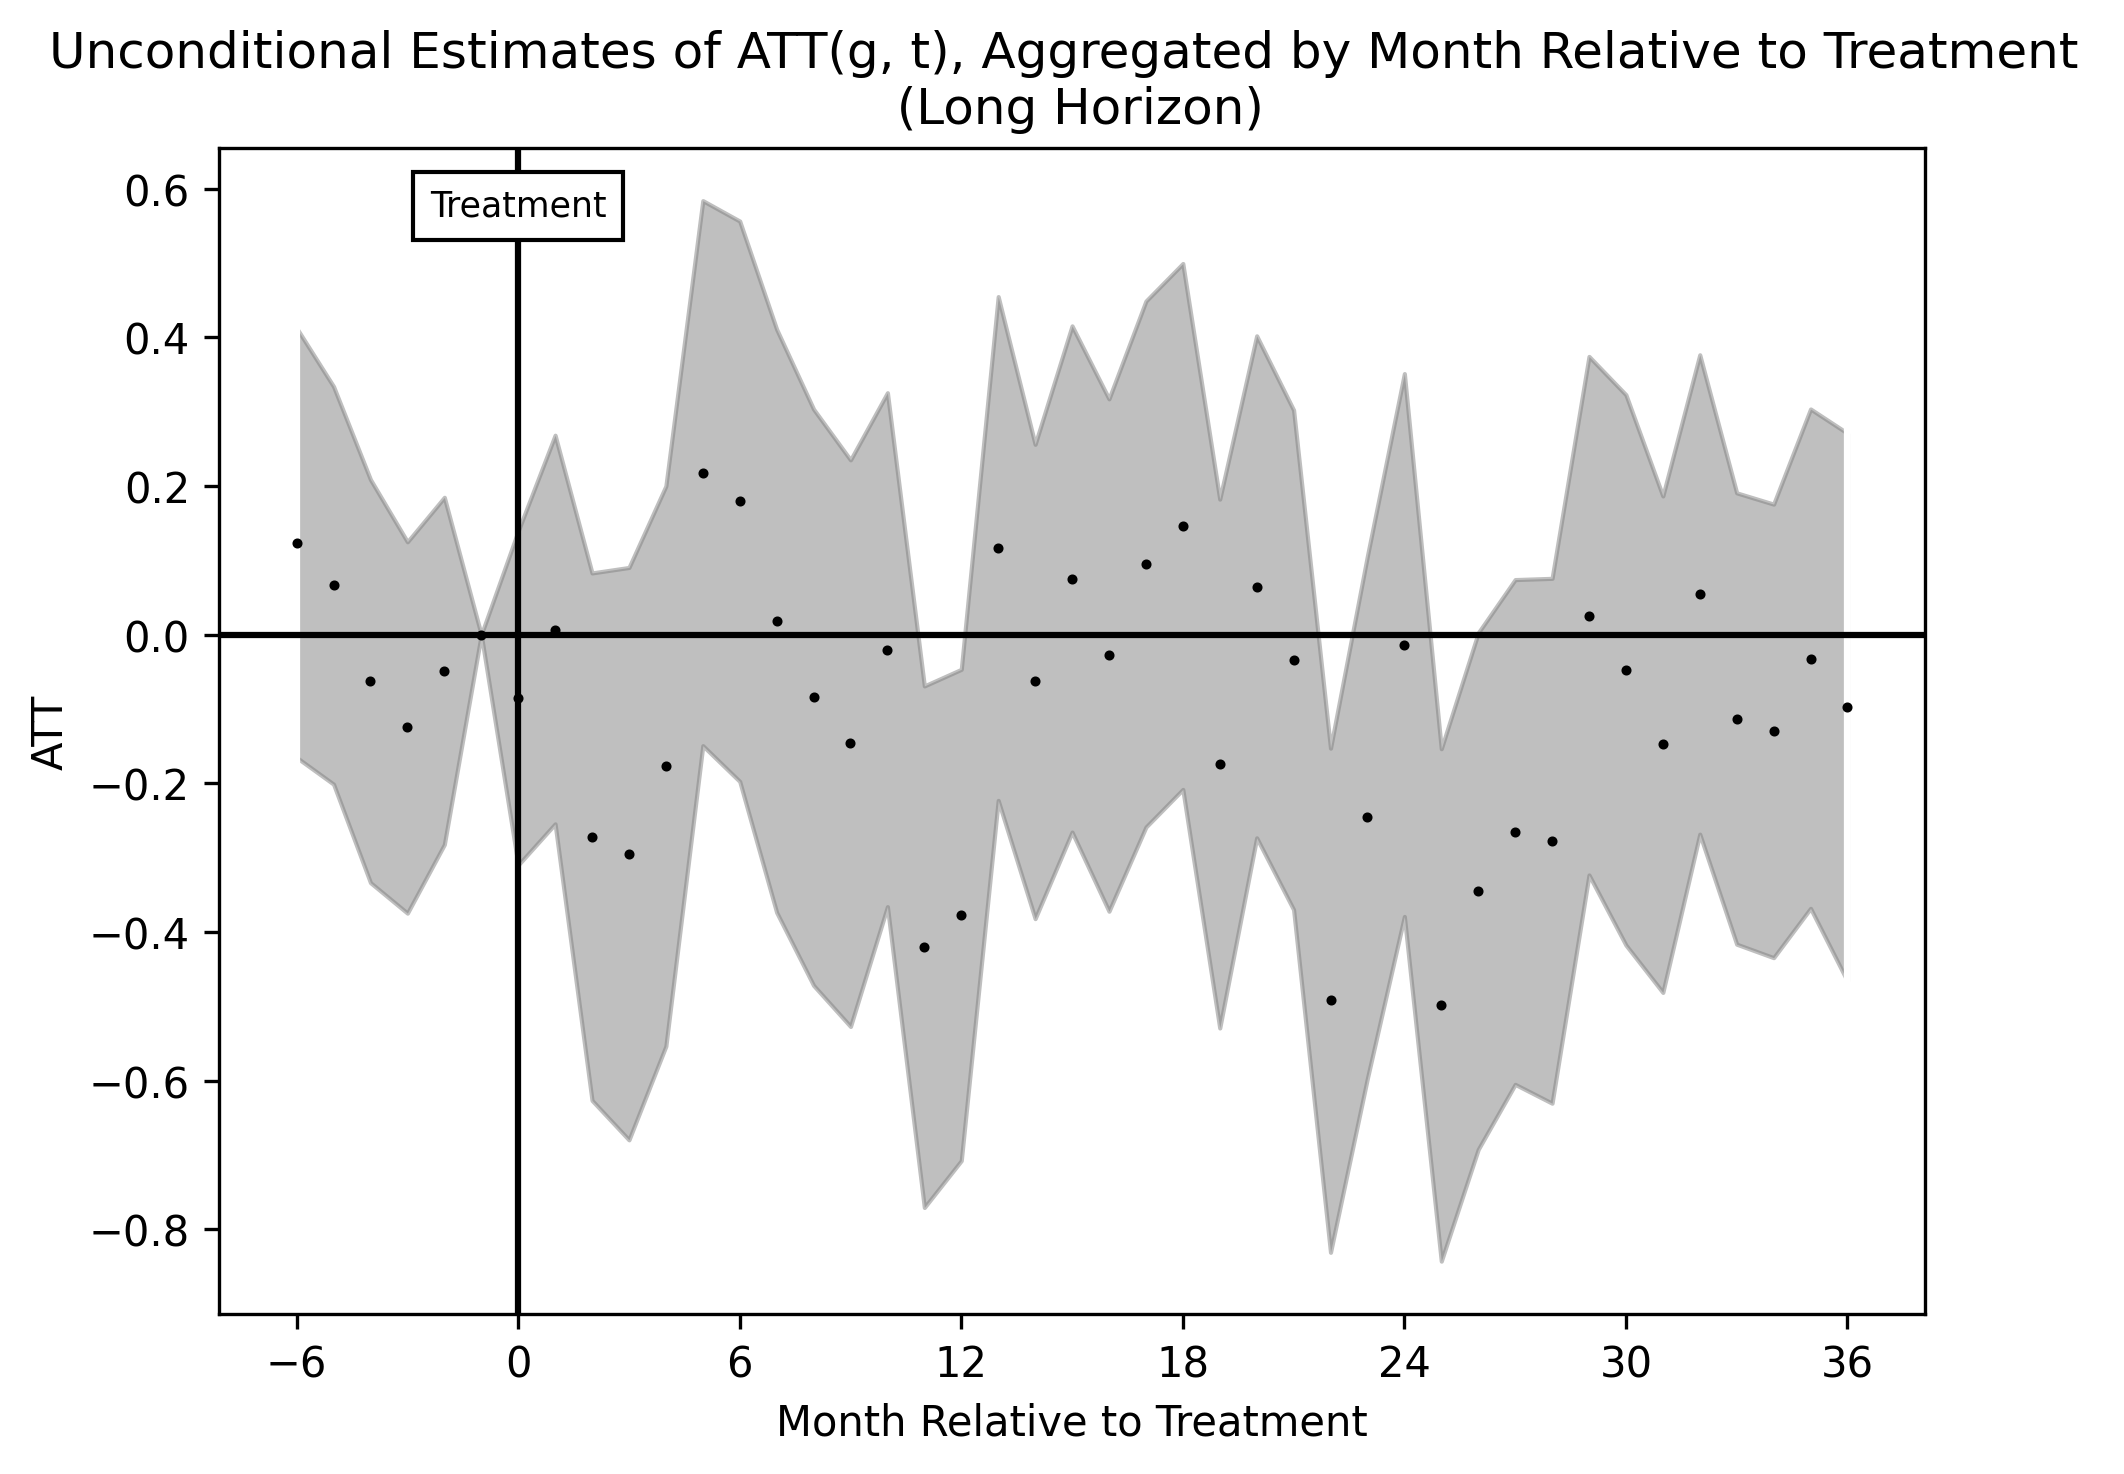

In [57]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [58]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=1, progress_bar=True)

Computing ATTgt [workers=1]   100%|████████████████████| 1104/1104 [00:18<00:00, 60.56it/s]


-0.5858976548730346
-0.0808416211266597
-0.1003951406574667
0.20230145349228326


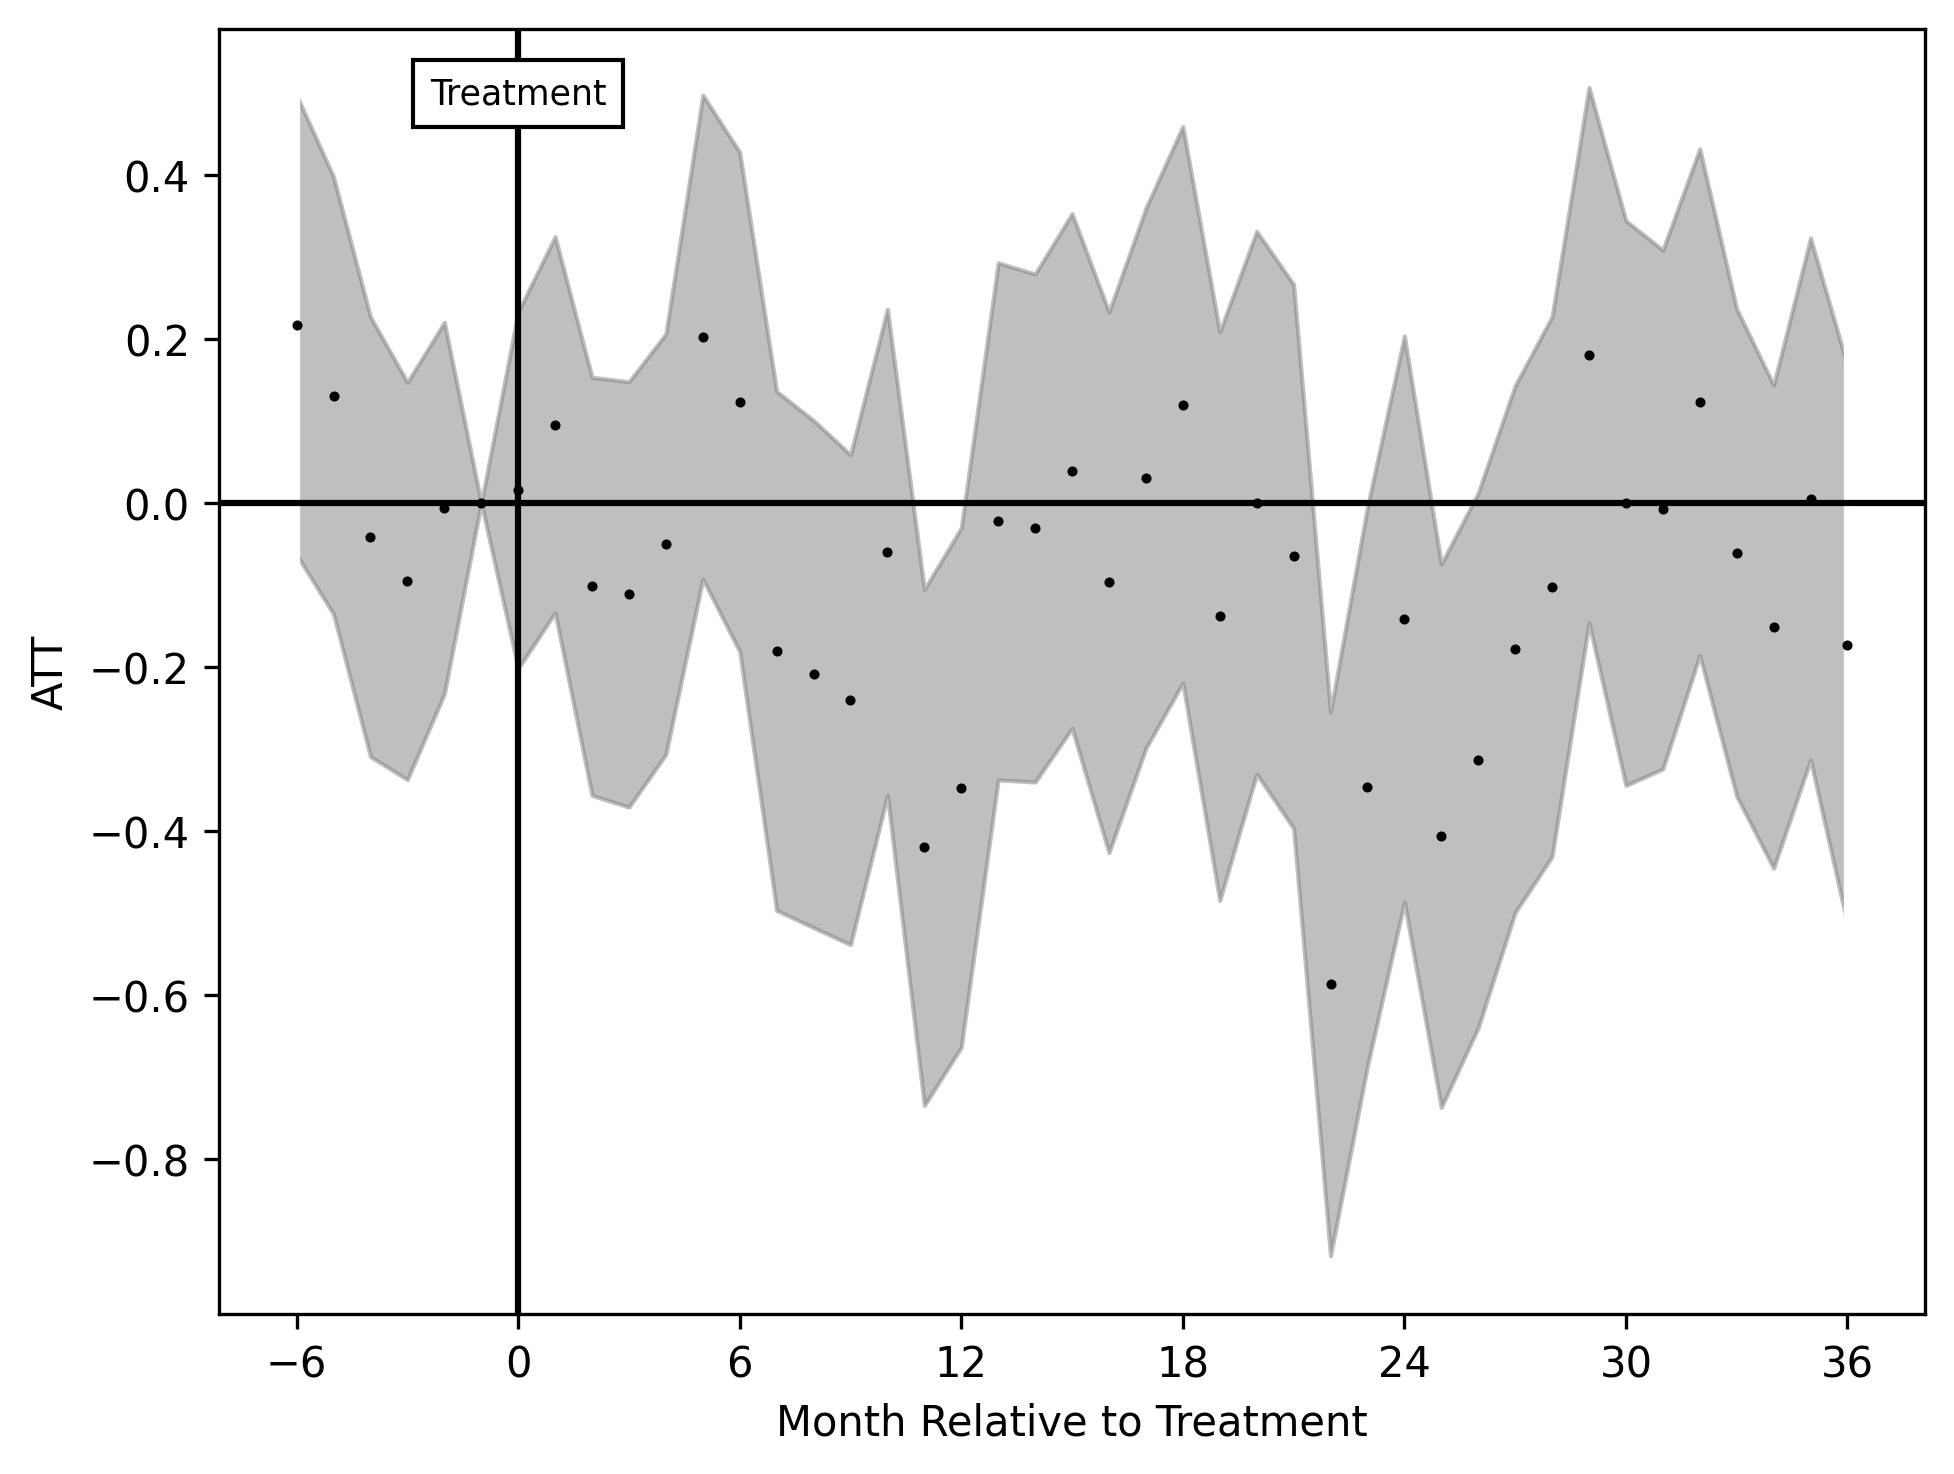

In [59]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)